In [4]:
import numpy as np
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import Model
import numpy as np
from PIL import Image
import datetime
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import tensorflow as tf

In [7]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [8]:
# Нормализация изображений
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Преобразование меток в one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Аугментация

In [9]:
# Создание объекта ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [142]:
datagen.fit(train_images)

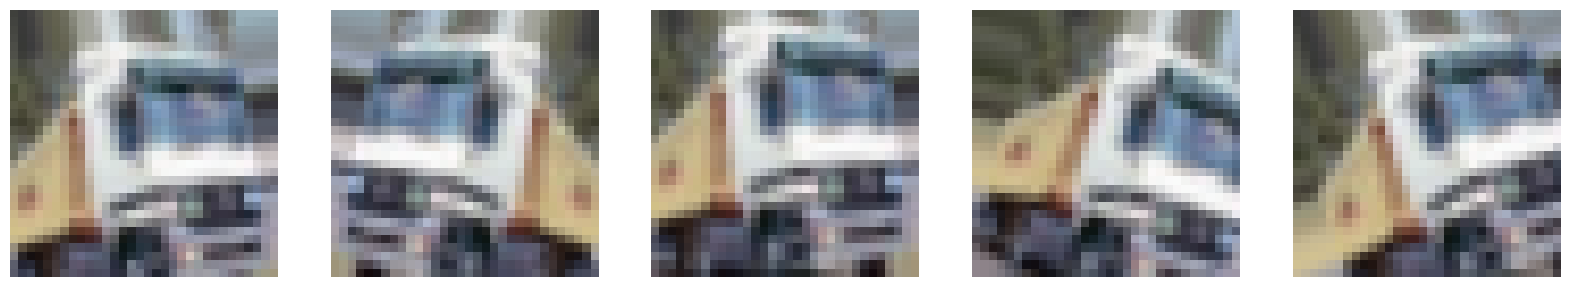

In [143]:
# Генерация аугментированных изображений
augmented_images = [train_images[1] for i in range(5)]
augmented_images = np.array(augmented_images)
augmented_images = datagen.flow(augmented_images, batch_size=5, shuffle=False).__next__()

# Визуализация изображений
fig, axarr = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    axarr[i].imshow(augmented_images[i])
    axarr[i].axis('off')

plt.show()


In [76]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [69]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), 
    MaxPooling2D((2, 2)), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)), 
    tf.keras.layers.Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'), 
    Flatten(), 
    Dense(64, activation='relu'), 
    Dense(10, activation='softmax')     
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=int(len(train_images) / 32),
          epochs=30,
          validation_data=(test_images, test_labels),
          callbacks=[early_stopping, reduce_lr, tensorboard_callback])

Epoch 1/30
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:30:01 3s/step - accuracy: 0.0938 - loss: 2.3338

C:\Users\User\PycharmProjects\TMSds\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.3057 - loss: 1.8699 - val_accuracy: 0.4847 - val_loss: 1.3967 - learning_rate: 0.0010
Epoch 2/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.3438 - loss: 1.6722 - val_accuracy: 0.4965 - val_loss: 1.3717 - learning_rate: 0.0010
Epoch 3/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.4898 - loss: 1.4134 - val_accuracy: 0.5394 - val_loss: 1.2767 - learning_rate: 0.0010
Epoch 4/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - accuracy: 0.4062 - loss: 1.4852 - val_accuracy: 0.5414 - val_loss: 1.2673 - learning_rate: 0.0010
Epoch 5/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.5365 - loss: 1.2937 - val_accuracy: 0.6123 - val_loss: 1.0876 - learning_rate: 0.0010
Epoch 6/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.5312 - loss: 1.1661 - val_accuracy: 0.6134 - val_loss: 1.0766 - learning_rate: 0.0010
Epoch 7/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.5668 

In [70]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

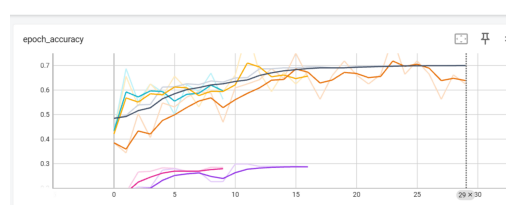

In [5]:
img = Image.open('img.png')
img_data = np.array(img)

plt.imshow(img_data)
plt.axis('off')  
plt.show()

# Optuna

In [71]:
import optuna
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


def objective(trial):
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)
    filters = [trial.suggest_int(f'filters_{i}', 16, 128, step=16) for i in range(num_conv_layers)]
    dense_units = trial.suggest_int('dense_units', 32, 128, step=32)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    model = Sequential()
    
    for i in range(num_conv_layers):
        if i == 0:
            model.add(Conv2D(filters[i], (3, 3), activation='relu', input_shape=(32, 32, 3)))
        else:
            model.add(Conv2D(filters[i], (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

    history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
                        steps_per_epoch=len(train_images) // 32,
                        epochs=10,
                        validation_data=(test_images, test_labels),
                        callbacks=[early_stopping, reduce_lr],
                        verbose=0)
    return history.history['val_accuracy'][-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)  
print('Number of finished trials:', len(study.trials))
print('Best trial:')
best_trial = study.best_trial
print(f'  Validation Accuracy: {best_trial.value:.4f}')
print('  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

print('\nAll trials:')
for trial in study.trials:
    print(f'Trial {trial.number}')
    print(f'  Validation Accuracy: {trial.value:.4f}')
    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')


[I 2024-06-24 15:13:09,314] A new study created in memory with name: no-name-5567eae3-8d86-4c66-863a-97bce12f5bf4
C:\Users\User\PycharmProjects\TMSds\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\PycharmProjects\TMSds\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1008.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarni

Number of finished trials: 15
Best trial:
  Validation Accuracy: 0.6734
  Params: 
    num_conv_layers: 3
    filters_0: 64
    filters_1: 64
    filters_2: 128
    dense_units: 64
    learning_rate: 0.0008624458990880117

All trials:
Trial 0
  Validation Accuracy: 0.5617
  Params: 
    num_conv_layers: 1
    filters_0: 96
    dense_units: 128
    learning_rate: 0.0023231893192694835
Trial 1
  Validation Accuracy: 0.6464
  Params: 
    num_conv_layers: 2
    filters_0: 80
    filters_1: 96
    dense_units: 64
    learning_rate: 0.00037036890028936876
Trial 2
  Validation Accuracy: 0.6420
  Params: 
    num_conv_layers: 2
    filters_0: 32
    filters_1: 64
    dense_units: 96
    learning_rate: 0.001599682908757084
Trial 3
  Validation Accuracy: 0.5672
  Params: 
    num_conv_layers: 2
    filters_0: 128
    filters_1: 80
    dense_units: 128
    learning_rate: 0.0030086855691491988
Trial 4
  Validation Accuracy: 0.5314
  Params: 
    num_conv_layers: 3
    filters_0: 32
    filters_1:

# применение лучших параметров с увеличением числа эпох

In [77]:
num_conv_layers = 3
filters = [64, 64, 128]
dense_units = 64
learning_rate = 0.0008624458990880117

model = Sequential()

for i in range(num_conv_layers):
    if i == 0:
        model.add(Conv2D(filters[i], (3, 3), activation='relu', input_shape=(32, 32, 3)))
    else:
        model.add(Conv2D(filters[i], (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(dense_units, activation='relu'))
model.add(Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
                    steps_per_epoch=len(train_images) // 32,
                    epochs=50,
                    validation_data=(test_images, test_labels),
                    callbacks=[early_stopping, reduce_lr,tensorboard_callback],
                    verbose=1)

print(f'Validation Accuracy: {history.history["val_accuracy"][-1]:.4f}')


Epoch 1/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.3016 - loss: 1.8852 - val_accuracy: 0.5219 - val_loss: 1.3303 - learning_rate: 8.6245e-04
Epoch 2/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3750 - loss: 1.7286 - val_accuracy: 0.5185 - val_loss: 1.3377 - learning_rate: 8.6245e-04
Epoch 3/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.4962 - loss: 1.3959 - val_accuracy: 0.5411 - val_loss: 1.3435 - learning_rate: 8.6245e-04
Epoch 4/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5938 - loss: 1.0530 - val_accuracy: 0.5500 - val_loss: 1.2992 - learning_rate: 8.6245e-04
Epoch 5/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.5461 - loss: 1.2747 - val_accuracy: 0.6238 - val_loss: 1.0761 - learning_rate: 8.6245e-04
Epoch 6/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5312 - loss: 1.3388 - val_accuracy: 0.6286 - val_loss: 1.0735 - learning_rate: 8.6245e-04
Epoch 7/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 40s 

# без аугментации

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from datetime import datetime

In [30]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)


In [31]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)


C:\Users\User\PycharmProjects\TMSds\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [34]:
history = model.fit(train_images, train_labels, epochs=30, 
                    validation_data=(test_images, test_labels),
                    callbacks=[early_stopping, reduce_lr,tensorboard_callback])

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.3470 - loss: 1.7629 - val_accuracy: 0.5492 - val_loss: 1.2578 - learning_rate: 0.0010
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5742 - loss: 1.1933 - val_accuracy: 0.6198 - val_loss: 1.0641 - learning_rate: 0.0010
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.6402 - loss: 1.0259 - val_accuracy: 0.6481 - val_loss: 1.0058 - learning_rate: 0.0010
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.6818 - loss: 0.9142 - val_accuracy: 0.6776 - val_loss: 0.9475 - learning_rate: 0.0010
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.7110 - loss: 0.8282 - val_accuracy: 0.6886 - val_loss: 0.8981 - learning_rate: 0.0010
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.7286 - loss: 0.7675 - val_accuracy: 0.6972 - val_loss: 0.8731 - learning_rate: 0.0010
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accura

In [36]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8940), started 0:00:47 ago. (Use '!kill 8940' to kill it.)

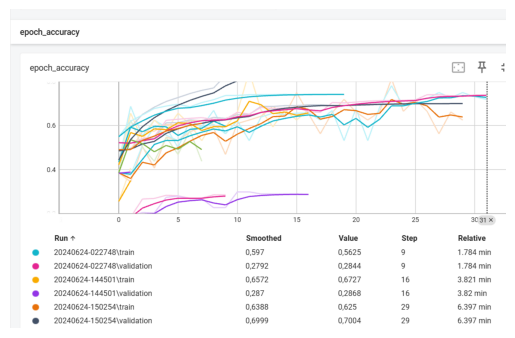

In [8]:
img = Image.open('img_1.png')
img_data = np.array(img)

plt.imshow(img_data)
plt.axis('off')  
plt.show()